## Gradient Boosting with XGBoost (60/20/20 split)


In [34]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
#!pip install xgboost

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

RANDOM_STATE = 42


### Step 1: Load Dataset

In [35]:
DATA_PATH = Path('churn_clean.csv')
df = pd.read_csv(DATA_PATH)
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Step 2: Prepare Features and Target

In [36]:
X = df.drop('Exited', axis=1)
y = df['Exited']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()
cat_cols, num_cols


(['Geography', 'Gender'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'])

### Step 3: Train/Validation/Test Split (60/20/20)

In [37]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print('Train:', X_train.shape, 'Target ratio:', y_train.mean().round(3))
print('Validation:', X_val.shape, 'Target ratio:', y_val.mean().round(3))
print('Test:', X_test.shape, 'Target ratio:', y_test.mean().round(3))


Train: (6000, 10) Target ratio: 0.204
Validation: (2000, 10) Target ratio: 0.204
Test: (2000, 10) Target ratio: 0.204


### Step 4: Build Preprocessing Pipeline

In [38]:
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer([
    ('categorical', ohe, cat_cols),
    ('numeric', StandardScaler(), num_cols)
])

preprocess.fit(X_train)

X_train_prepared = preprocess.transform(X_train)
X_val_prepared = preprocess.transform(X_val)
X_test_prepared = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()
X_train_prepared.shape


(6000, 13)

### Step 5: Train XGBoost with Early Stopping

In [39]:
#!pip install -U xgboost


In [40]:
import xgboost
print(xgboost.__version__)


3.1.1


In [41]:
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=5,
    learning_rate=0.05,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

In [42]:
xgb_clf.fit(
    X_train_prepared, y_train,
    eval_set=[(X_val_prepared, y_val)],
    # early_stopping_rounds=50,
    verbose=50
)

[0]	validation_0-auc:0.78474


[50]	validation_0-auc:0.87630
[100]	validation_0-auc:0.87722
[150]	validation_0-auc:0.87934
[200]	validation_0-auc:0.87801
[250]	validation_0-auc:0.87512
[300]	validation_0-auc:0.87310
[350]	validation_0-auc:0.87063
[400]	validation_0-auc:0.86839
[450]	validation_0-auc:0.86682
[500]	validation_0-auc:0.86499
[550]	validation_0-auc:0.86491
[600]	validation_0-auc:0.86347
[650]	validation_0-auc:0.86219
[700]	validation_0-auc:0.86013
[750]	validation_0-auc:0.85834
[800]	validation_0-auc:0.85710
[850]	validation_0-auc:0.85635
[900]	validation_0-auc:0.85526
[950]	validation_0-auc:0.85391
[999]	validation_0-auc:0.85337


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


### Step 6: Evaluate Performance

In [43]:
y_val_pred = xgb_clf.predict(X_val_prepared)
y_val_proba = xgb_clf.predict_proba(X_val_prepared)[:, 1]
y_test_pred = xgb_clf.predict(X_test_prepared)
y_test_proba = xgb_clf.predict_proba(X_test_prepared)[:, 1]


In [44]:
print('Validation ROC-AUC:', round(roc_auc_score(y_val, y_val_proba), 3))
print(classification_report(y_val, y_val_pred))
print('Test ROC-AUC:', round(roc_auc_score(y_test, y_test_proba), 3))
print(classification_report(y_test, y_test_pred))


Validation ROC-AUC: 0.853
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1592
           1       0.69      0.50      0.58       408

    accuracy                           0.85      2000
   macro avg       0.78      0.72      0.75      2000
weighted avg       0.84      0.85      0.84      2000

Test ROC-AUC: 0.836
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1593
           1       0.69      0.51      0.58       407

    accuracy                           0.85      2000
   macro avg       0.79      0.72      0.75      2000
weighted avg       0.84      0.85      0.84      2000



In [45]:
val_cm = confusion_matrix(y_val, y_val_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
val_cm, test_cm


(array([[1498,   94],
        [ 202,  206]]),
 array([[1500,   93],
        [ 201,  206]]))

### Step 7: Visual Diagnostics

In [46]:
FIG_DIR = Path('figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [47]:
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)
val_auc = roc_auc_score(y_val, y_val_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

val_prec, val_rec, _ = precision_recall_curve(y_val, y_val_proba)
test_prec, test_rec, _ = precision_recall_curve(y_test, y_test_proba)
val_ap = average_precision_score(y_val, y_val_proba)
test_ap = average_precision_score(y_test, y_test_proba)


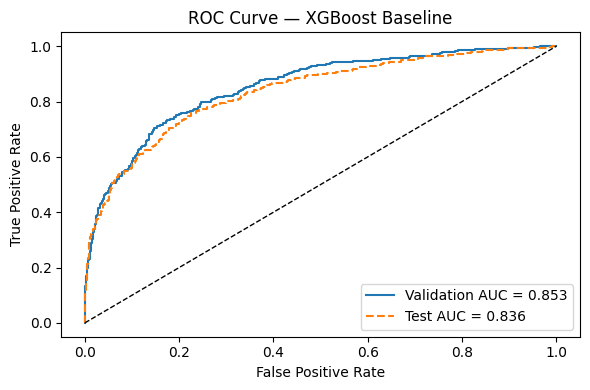

In [48]:
plt.figure(figsize=(6, 4))
plt.plot(val_fpr, val_tpr, label=f'Validation AUC = {val_auc:.3f}')
plt.plot(test_fpr, test_tpr, label=f'Test AUC = {test_auc:.3f}', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — XGBoost Baseline')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve_xgb_baseline.png', dpi=200)
plt.show()


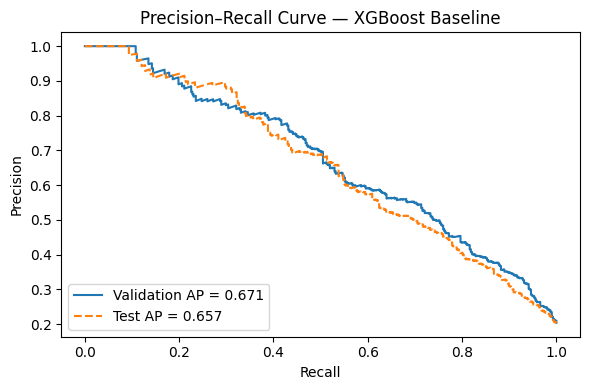

In [49]:
plt.figure(figsize=(6, 4))
plt.plot(val_rec, val_prec, label=f'Validation AP = {val_ap:.3f}')
plt.plot(test_rec, test_prec, label=f'Test AP = {test_ap:.3f}', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve — XGBoost Baseline')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(FIG_DIR / 'pr_curve_xgb_baseline.png', dpi=200)
plt.show()


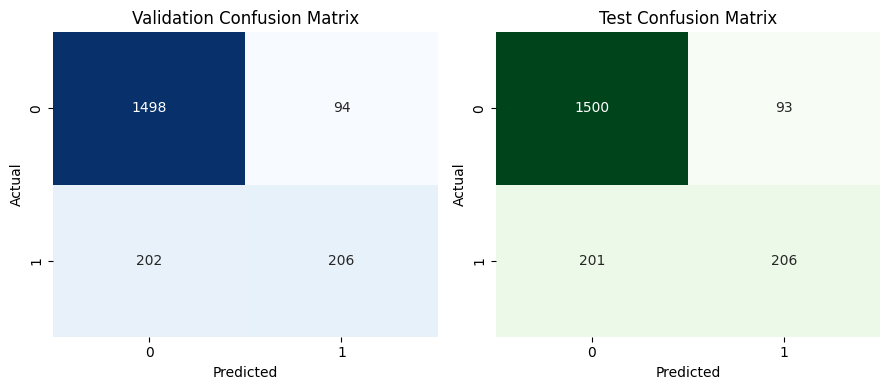

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Validation Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrices_xgb_baseline.png', dpi=200)
plt.show()


### Step 8: Feature Importance (Gain)

In [51]:
importances = pd.Series(xgb_clf.feature_importances_, index=feature_names)
top_features = importances.sort_values(ascending=False).head(20)
top_features


numeric__NumOfProducts            0.266381
numeric__IsActiveMember           0.118623
categorical__Geography_Germany    0.106320
numeric__Age                      0.097517
numeric__Balance                  0.056811
categorical__Gender_Male          0.050771
categorical__Gender_Female        0.046357
categorical__Geography_France     0.045966
categorical__Geography_Spain      0.045000
numeric__EstimatedSalary          0.044814
numeric__CreditScore              0.043949
numeric__Tenure                   0.039609
numeric__HasCrCard                0.037882
dtype: float32

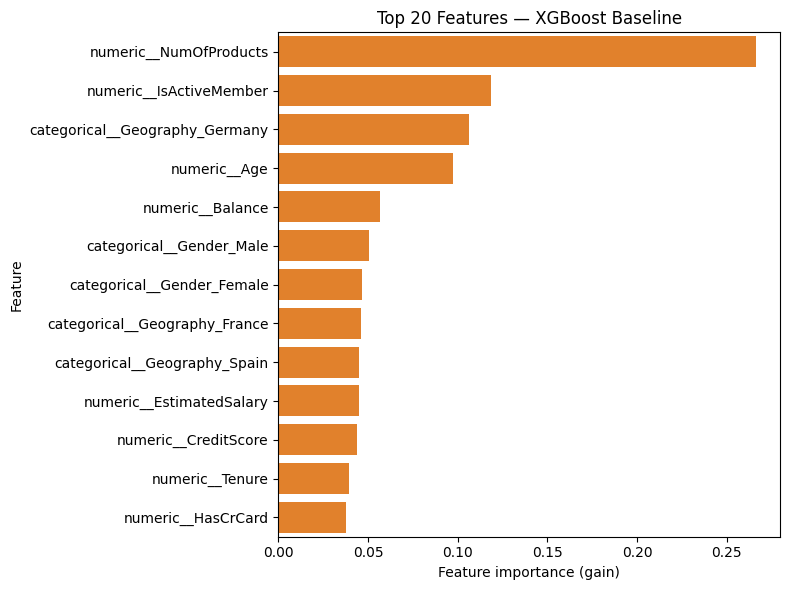

In [52]:
plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, color='tab:orange')
plt.xlabel('Feature importance (gain)')
plt.ylabel('Feature')
plt.title('Top 20 Features — XGBoost Baseline')
plt.tight_layout()
plt.show()


### Step 9: Persist Model and Preprocessor

In [53]:
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / 'xgb_baseline.joblib'
joblib.dump({'model': xgb_clf, 'preprocess': preprocess}, MODEL_PATH)
MODEL_PATH


PosixPath('models/xgb_baseline.joblib')

### Step 10: Notes

- Early stopping monitors validation AUC and halts boosting when the metric stops improving.
- Compare ROC-AUC and PR-AUC against other baselines to judge lift.
- Reload with `joblib.load` to score new customers consistently via the stored preprocessor + model.